In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import cv2
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline


In [16]:
ad = 'C:/Users/Saumya Sah/Desktop/wbdataset/train'
CAT = ['w1','w2','w3','w4', 'w5']


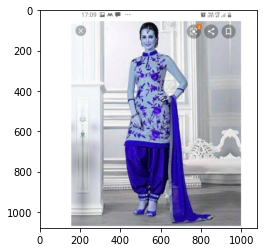

In [17]:
for cat in CAT:
    path = ad + '/' + cat + '/'
    for img in os.listdir(path):
        img_array = cv2.imread(ad+'/'+cat + '/'+img)
        plt.imshow(img_array)
        plt.show
        break
    break    

In [18]:
training_data = []
def create_training_data():
    for cat in CAT:
        path = ad + '/' + cat + '/'
        class_num = CAT.index(cat)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(ad+'/'+cat + '/'+img)
                newarr = cv2.resize(img_array, (150,150))
                training_data.append([newarr,class_num])   
            except Exception as e:
                pass
            
create_training_data()  

In [19]:
import random
random.shuffle(training_data)

In [20]:
X=[]
y=[]
import numpy
for features, label in training_data:
    X.append(features)
    y.append(label)
X = np.array(X).reshape(-1, 150, 150, 3)/255
#print(X.shape)
noofegs= X.shape[0]
y_new= []
for n in y:
    t=np.zeros([5,1])
    t[n]=1
    y_new.append(t)
y_new = np.array(y_new).reshape(noofegs,5)


In [21]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
#from resnets_utils import *
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [22]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
  ##  X = Conv2D(filters=F2, kernel_size = (f, f),strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform())(X)
   # X = BatchNormalization(axis= 3, name = bn_name_base + '2b')(X)
   # X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters=F3, kernel_size = (1, 1),strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [23]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding='valid',name = conv_name_base + '2a', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
  #  X = Conv2D(F2, (f, f), strides = (1,1),padding='same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform())(X)
   # X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
   # X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1),padding='valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s),padding='valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform())(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [24]:
def ResNet50(input_shape = (150, 150, 3), classes = 5):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (10, 10), strides = (3, 3), name = 'conv1', kernel_initializer = glorot_uniform())(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((5, 5), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 5, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    #X = identity_block(X, 5, [64, 64, 256], stage=21, block='b')
    X = identity_block(X, 5, [64, 64, 256], stage=22, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 5, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    #X = identity_block(X, 5, [128, 128, 512], stage=31, block='b')
    X = identity_block(X, 5, [128, 128, 512], stage=32, block='c')
    X = identity_block(X, 5, [128, 128, 512], stage=33, block='d')

    #Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 5, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    #X = identity_block(X, 5, [256, 256, 1024], stage=41, block='b')
    #X = identity_block(X, 5, [256, 256, 1024], stage=42, block='c')
    X = identity_block(X, 5, [256, 256, 1024], stage=43, block='d')
    X = identity_block(X, 5, [256, 256, 1024], stage=44, block='e')
    X = identity_block(X, 5, [256, 256, 1024], stage=45, block='f') 

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 5, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    #X = identity_block(X, 5, [512, 512, 2048], stage=51, block='b')
    X = identity_block(X, 5, [512, 512, 2048], stage=52, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D()(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform())(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [25]:
model = ResNet50(input_shape = (150, 150, 3), classes = 5)

In [26]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
model.fit(X, y_new, epochs = 30)

Epoch 1/30
243/243 [==============================] - 17s 68ms/step - loss: 3.0775 - accuracy: 0.2510
Epoch 2/30
243/243 [==============================] - 14s 58ms/step - loss: 2.9811 - accuracy: 0.2716
Epoch 3/30
243/243 [==============================] - 14s 59ms/step - loss: 1.7481 - accuracy: 0.3292
Epoch 4/30
243/243 [==============================] - 14s 59ms/step - loss: 1.4351 - accuracy: 0.4650
Epoch 5/30
243/243 [==============================] - 14s 59ms/step - loss: 1.1428 - accuracy: 0.5885
Epoch 6/30
243/243 [==============================] - 15s 60ms/step - loss: 0.8543 - accuracy: 0.6626
Epoch 7/30
243/243 [==============================] - 14s 59ms/step - loss: 0.8179 - accuracy: 0.7449
Epoch 8/30
243/243 [==============================] - 14s 59ms/step - loss: 0.6095 - accuracy: 0.7572
Epoch 9/30
243/243 [==============================] - 14s 59ms/step - loss: 0.6010 - accuracy: 0.7613
Epoch 10/30
243/243 [==============================] - 14s 59ms/step - loss: 0.443

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.
